In [1]:
import pandas as pd
import numpy as np
#from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.decomposition import PCA
import time
start_time = time.time()

In [2]:
from dask.distributed import Client
client = Client(n_workers=1, threads_per_worker=4)

In [3]:
client

Client Scheduler: tcp://127.0.0.1:63223 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 4 Memory: 7.89 GiB


# Data loading and exploring

In [4]:
# http://archive.ics.uci.edu/ml/datasets/Covertype

In [5]:
df = pd.read_csv(r'http://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz',sep=None, header=None, engine='python')
# Make the columns readable instead of just numbers.
columns = [
'Elevation',                              
'Aspect',                           
'Slope',                              
'Horizontal_Distance_To_Hydrology',     
'Vertical_Distance_To_Hydrology',       
'Horizontal_Distance_To_Roadways',         
'Hillshade_9am',                          
'Hillshade_Noon',                         
'Hillshade_3pm',                           
'Horizontal_Distance_To_Fire_Points'    
]
dummies = [[f'Wilderness_Area_{x}' for x in np.arange(0,4)], [f'Soil_Type_{x}' for x in np.arange(0,40)]]
columns.extend(dummies[0])
columns.extend(dummies[1])
#columns.extend([f'Wilderness_Area_{x}' for x in np.arange(0,4)])
#columns.extend([f'Soil_Type_{x}' for x in np.arange(0,40)])          
columns.append('Cover_Type') 

df.columns = columns

In [6]:
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [7]:
print(f'This dataframe has {len(df)} samples with {len(df.columns)-1} variables')

This dataframe has 581012 samples with 54 variables


In [8]:
df.dtypes

Elevation                             int64
Aspect                                int64
Slope                                 int64
Horizontal_Distance_To_Hydrology      int64
Vertical_Distance_To_Hydrology        int64
Horizontal_Distance_To_Roadways       int64
Hillshade_9am                         int64
Hillshade_Noon                        int64
Hillshade_3pm                         int64
Horizontal_Distance_To_Fire_Points    int64
Wilderness_Area_0                     int64
Wilderness_Area_1                     int64
Wilderness_Area_2                     int64
Wilderness_Area_3                     int64
Soil_Type_0                           int64
Soil_Type_1                           int64
Soil_Type_2                           int64
Soil_Type_3                           int64
Soil_Type_4                           int64
Soil_Type_5                           int64
Soil_Type_6                           int64
Soil_Type_7                           int64
Soil_Type_8                     

In [9]:
df.isna().sum().sum()

0

No missing values and types are correct

In [10]:
from dask_ml.decomposition import PCA
from dask_ml.model_selection import train_test_split
import dask.dataframe as dd
df = dd.from_pandas(df, npartitions=4)

In [11]:
X = df.drop('Cover_Type', axis=1)
y = df['Cover_Type']
# Making the train and test set
# start y from zero
y = y - 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=True)

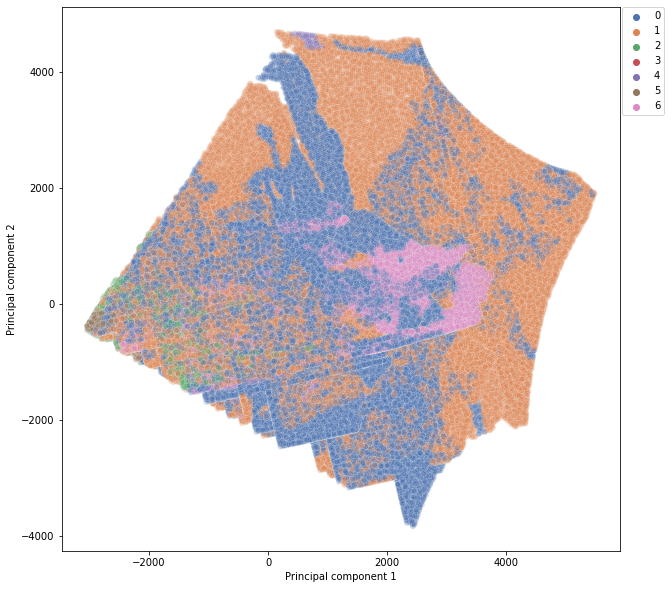

In [12]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train.to_dask_array(lengths=True))
X_test_pca = pca.transform(X_test.to_dask_array(lengths=True))
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train, palette="deep", ax=ax, alpha=0.3)
plt.legend(bbox_to_anchor=(1.08, 1),
           borderaxespad=0)
ax.set_xlabel('Principal component 1')
ax.set_ylabel('Principal component 2')
plt.show()

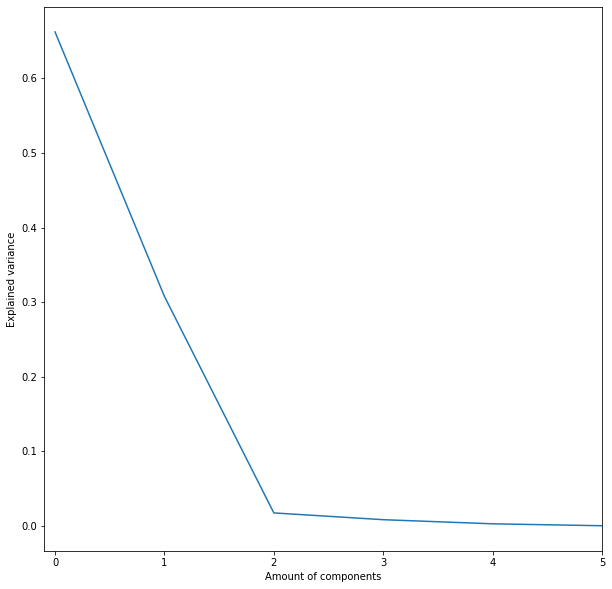

In [13]:
fig, ax = plt.subplots(figsize=(10,10))
explained_variance = pca.explained_variance_ratio_
sns.lineplot(x=np.arange(0, len(explained_variance)), y=explained_variance, ax=ax)
ax.set_xlabel('Amount of components')
ax.set_ylabel('Explained variance')
plt.xlim(-0.1, 5)
plt.show()

The groups aren't clearly seperated in the PCA plot. What is interesting however is that 1 principal componant can almost explain all the variance in the data. 

# Building the models

In [14]:
from dask_ml.model_selection import KFold
#from dask_ml.metrics import plot_confusion_matrix, plot_roc_curve, classification_report
#from sklearn.model_selection import KFold
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report

In [15]:
# Quickly look at the amount of train and test samples

In [16]:
X_train.shape

(Delayed('int-528dbf8e-57a0-40e6-a047-f5175cdaaf24'), 54)

In [17]:
X_test.shape

(Delayed('int-c26877bc-7b1d-47a1-b747-c27e61b7d6c7'), 54)

# First a simple baseline will be build

In [18]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier(strategy='most_frequent')
clf.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

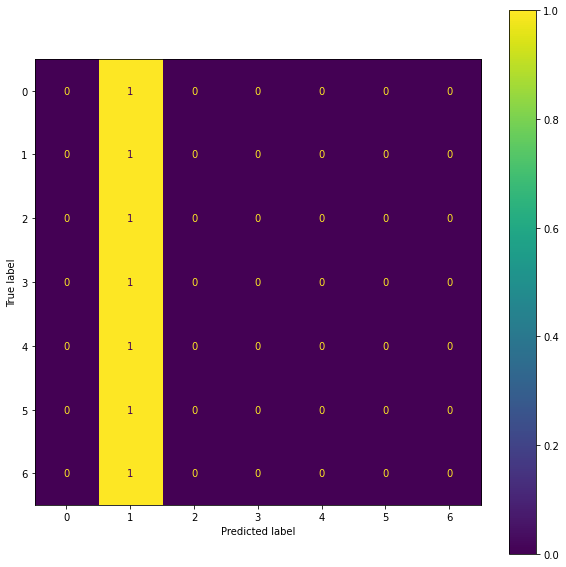

In [19]:
f, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(clf, X_test, y_test, ax=ax, normalize='true')
plt.show()

In [20]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     63220
           1       0.49      1.00      0.66     84900
           2       0.00      0.00      0.00     10871
           3       0.00      0.00      0.00       856
           4       0.00      0.00      0.00      2912
           5       0.00      0.00      0.00      5367
           6       0.00      0.00      0.00      6124

    accuracy                           0.49    174250
   macro avg       0.07      0.14      0.09    174250
weighted avg       0.24      0.49      0.32    174250



In [21]:
# Not a binary problem so no ROC curce is used

Due  to  its  highly competitive  environment  (some  contests  have  thousands  of  entrants  and  million-dollar prizes) and to the wide variety of machine-learning problems covered, Kaggle offers a realistic way to assess what works and what doesn’t. In  2016  and  2017,  Kaggle  was  dominated  by  two  approaches:  gradient  boosting machines  and  deep  learning.(deep learning with python François Chollet). Because deep learning is outside the scope of this project the first algorithm made will be a gradient  boosting machines.

In [22]:
import dask_ml.xgboost as xgb
clf = xgb.XGBClassifier(n_estimators=50, 
                        objective='multi:softprob',num_class=7, eval_metric=['mlogloss'], 
                        use_label_encoder =False)

In [23]:
clf.fit(X_train, y_train)
clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric=['mlogloss'],
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=4, num_class=7,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='approx', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [24]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred.compute(), zero_division=0))

              precision    recall  f1-score   support

           0       0.82      0.81      0.82     63220
           1       0.83      0.87      0.85     84900
           2       0.84      0.87      0.85     10871
           3       0.86      0.87      0.87       856
           4       0.88      0.37      0.52      2912
           5       0.77      0.62      0.69      5367
           6       0.91      0.85      0.88      6124

    accuracy                           0.83    174250
   macro avg       0.85      0.75      0.78    174250
weighted avg       0.83      0.83      0.83    174250



In [25]:
end_time = time.time()
print(end_time - start_time)

298.0083329677582
